### This notebook is designed to make a Dataframe with rear events that are borderless and associate the beacon location with it
It will center all positions and rotate beacons by the amount they were before hand and create indices for Vissucc, InvisSucc or InvisUnsecc Make one large data frame with all rears. 
Then it shoud plot the histograms and save them in figures. 

# TODO: 

better Z point averaging - across the rear - Discussed - could make an average displacement plot but will likely stick with same detections as now 

improve border-borderless detection - Arena calibration file  - DONE

Find correct translation of beacons for more accurate detection shoudl be DONE was off by a little bit. 

Add trial number 

NOw simplify analysis to detect if visibel beacon or not. - compare if rear in between visibel or invisible beacons. 


In [17]:
import math
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from numpy import median
from scipy.stats import ranksums
import numpy as np
import scipy.stats
import os
import fnmatch

#### imports for a sample session

In [18]:
root = '//10.153.170.3/storage2/fabian/data/project/CALIBRATION/'
root3 = '//10.153.170.3/storage2/fabian/data/raw/Event_files_FS03/'
root4 = '//10.153.170.3/storage2/fabian/data/raw/Event_files_FS04/'
figures = 'C:/Users/Fabian/Desktop/Analysis/Round3_FS03_FS06/Figures/'
animal = '//10.153.170.3/storage2/fabian/data/raw/Event_files_FS03/'
processed= 'C:/Users/Fabian/Desktop/Analysis/Round3_FS03_FS06/processed/'

FS03_position= pd.read_csv(root3+'position_20210312-172823.txt',sep=" ", header=None)
FS04_position = pd.read_csv(root4+'position_20210322-202458.txt',sep=" ", header=None)

FS03_beacon = pd.read_csv(root3+'beacons_20210312-172823.txt',sep=" ", header=None)
FS04_beacon = pd.read_csv(root4+'beacons_20210322-202458.txt',sep=" ", header=None)

pd.options.display.float_format = '{:.3f}'.format

In [56]:
FS03_position.head()

,0,1,2,3,4,5,6,7,8,9
0,1615566503.650,0.068,0.473,0.311,-8.803,-173.105,-16.893,1810,13075943.081,0.208
1,1615566503.660,0.067,0.478,0.318,-6.802,-172.775,-14.545,1812,13075943.097,0.225
2,1615566503.680,0.066,0.485,0.327,-5.331,-173.292,-10.482,1814,13075943.114,0.242
3,1615566503.690,0.064,0.494,0.336,-3.791,-173.008,-6.319,1816,13075943.131,0.258
4,1615566503.710,0.065,0.502,0.345,-4.207,-172.265,-4.026,1818,13075943.147,0.275


### Rotation format

In [57]:
##(xcosθ−ysinθ ,xsinθ+ycosθ).
def rotation_correction_points(position_data,alpha=1.7):
    alpha = (alpha) * np.pi / 180
    rot_position_data = position_data
    rot_position_data[1] = position_data[1] * np.cos(alpha) - position_data[3] * np.sin(alpha)
    rot_position_data[3] = position_data[1] * np.sin(alpha) + position_data[3] * np.cos(alpha)
    return rot_position_data
def rotation_correction_beacons(position_data,alpha=-5):
    alpha = (alpha) * np.pi / 180
    rot_position_data = position_data
    rot_position_data["BeaconX"] = position_data["BeaconX"] * np.cos(alpha) - position_data["BeaconY"] * np.sin(alpha)
    rot_position_data["BeaconY"] = position_data["BeaconX"] * np.sin(alpha) + position_data["BeaconY"] * np.cos(alpha)
    return rot_position_data


### Steps to do to the data: 
    A. Make rearign file >.62 
    B. propely name beacon file for visible succesfull or not 
    B2. Make a third dataframe to get times when beacon visible or invisible
    C. Merge rearign file with beacon addign beacon location to when they reared
    D. Name invisible uncusseful, time from beacon and beacon rear group (which rear to which beacon - color)
    E. Normalize all positions - translate and rotate positions and rotate beacons by 1.7. 
    F. Run it all in one cell for all files - scraping and name columns 
    G. Sanity check - plot succesful rear position subtracted from beacon position - if off the center can recalculate. 

### Borders of arena - hardcoded from calibration file 

In [58]:
cut = 0 # keeping the cut where rectangle of arena ends
X_cut_min = -.59
Y_cut_max = 1.61
X_cut_max = .12
Y_cut_min = .00
print("area %s M*2" %((X_cut_max-X_cut_min)*(Y_cut_max-Y_cut_min))) 
#Translations
x_max, x_min = 0.12, -0.59
x_offset = x_max - (x_max - x_min)/2
y_max, y_min = 1.61,  0
y_offset = y_max - (y_max - y_min)/2
print(x_offset,y_offset)
xcut_offset=-.24
ycut_offset=-.8
#alpha
rotation= 1.7

area 1.1431 M*2
-0.235 0.805


### Show Output from Arena with added beacons - They were a bit off to begin with and shoudl be so for calculations

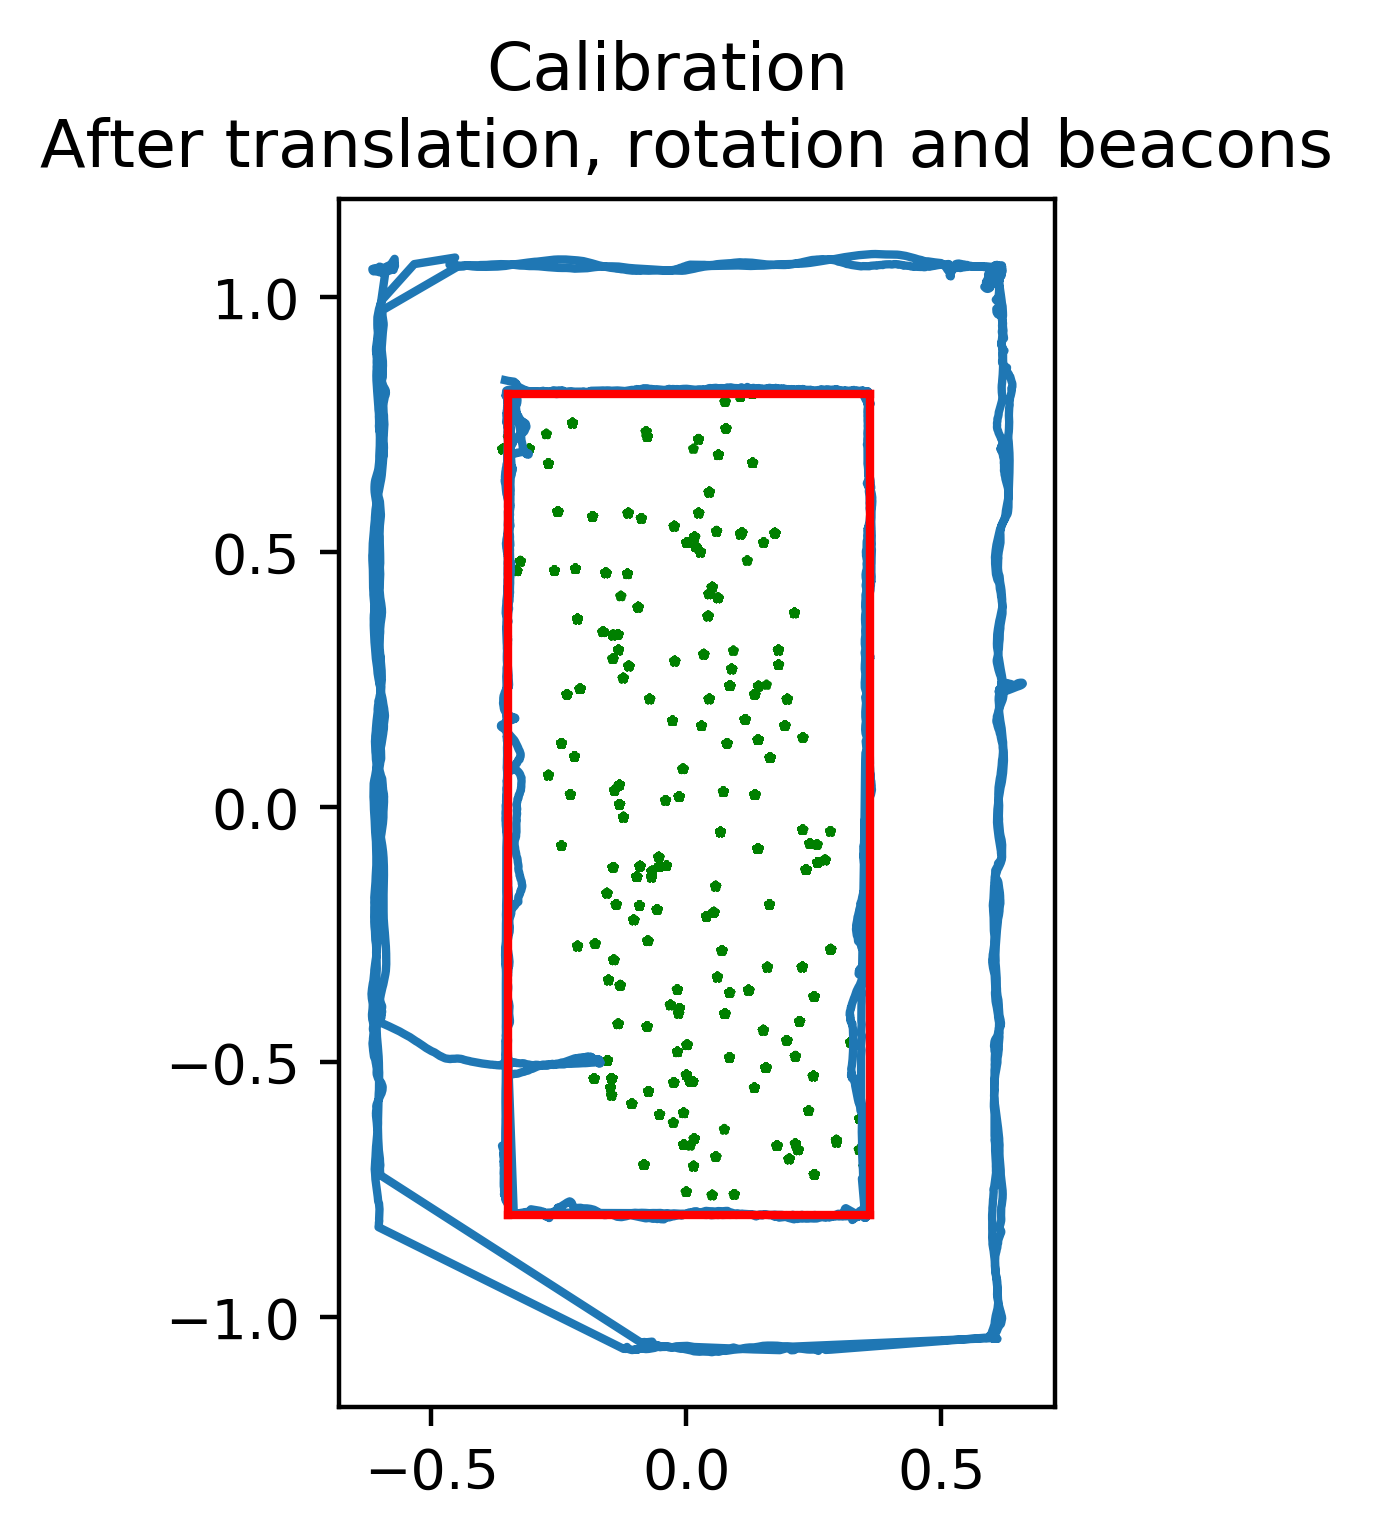

In [59]:
CALIB1 = pd.read_csv(root+'BPositions_CALIBRATION_20210610-111132/position_20210610-111132.txt',sep=" ", header=None)    
CALIB1[1]= CALIB1[1]-xcut_offset
CALIB1[3]= CALIB1[3]+ycut_offset
rot_position_data=  rotation_correction_points(CALIB1,alpha=rotation)
fig, ax1 = plt.subplots(1, 1, sharex=True,dpi=400, sharey=True)
fig.suptitle("Calibration")
ax1.set_title('After translation, rotation and beacons ')
rearing3 = pd.read_excel(processed +'FS03_rears.xlsx')
rearing3 = rotation_correction_beacons(rearing3,alpha=1.7)
ax1.plot(rot_position_data[1],rot_position_data[3])
ax1.plot([(X_cut_min+cut)-xcut_offset,(X_cut_max-cut)-xcut_offset],[(Y_cut_max-cut)+ycut_offset,(Y_cut_max-cut)+ycut_offset] ,'r-')
ax1.plot([(X_cut_min+cut)-xcut_offset,(X_cut_min+cut)-xcut_offset],[(Y_cut_min+cut)+ycut_offset,(Y_cut_max-cut)+ycut_offset] ,'r-')
ax1.plot([(X_cut_max-cut)-xcut_offset,(X_cut_max-cut)-xcut_offset],[(Y_cut_min+cut)+ycut_offset,(Y_cut_max-cut)+ycut_offset] ,'r-')
ax1.plot([(X_cut_max-cut)-xcut_offset,(X_cut_min+cut)-xcut_offset],[(Y_cut_min+cut)+ycut_offset,(Y_cut_min+cut)+ycut_offset] ,'r-')
ax1.scatter(rearing3["BeaconX"],rearing3["BeaconY"],s=1,marker='*', facecolors='none', edgecolors='green')
plt.gca().set_aspect('equal')

### A. get secific point per rear event in center of arena

In [70]:
def Z_period_points(positions): 
    high =0 
    low = 0
    switch = 0 
    last = .60
    high_points=[]
    z= positions[2]
    count = 0 
    for height in z: 
        if height >.62 and last<.62:
            high +=1  
            if  (X_cut_min+cut)< positions[1][count]<(X_cut_max-cut) and (Y_cut_min+cut)< positions[3][count]<(Y_cut_max-cut):
                high_points.append((positions[0][count],positions[1][count],positions[3][count],positions[2][count]))
        last = height
        count +=1
        
    return pd.DataFrame(high_points)
Z_points= Z_period_points(FS03_position)
Z_points

,0,1,2,3
0,1615566506.380,-0.509,0.334,0.628
1,1615566510.780,-0.441,0.248,0.625
2,1615566529.700,-0.425,0.719,0.629
3,1615566534.740,-0.568,1.607,0.622
4,1615566547.110,-0.583,1.587,0.622
5,1615566562.340,-0.570,0.019,0.640
6,1615566568.820,0.062,0.048,0.622
7,1615566572.920,-0.501,0.392,0.625
8,1615566574.530,-0.487,0.271,0.622
9,1615566591.010,-0.488,0.341,0.620


### B. Add 6th column to beacon file if visible or not

In [71]:
def vis_invis(beacon): 
    visibility=[]
    for i in beacon.index:
        if(i % 2 == 0):
            visibility.append(1)
        else:
            visibility.append(0)
    beacon[6]=visibility
    return beacon
FS03_beacon=vis_invis(FS03_beacon) 
FS03_beacon.head()

,0,1,2,3,4,5,6,7
0,1615566511.420,-0.403,0.693,0.304,-0.177,-0.524,1,1615566511.420
1,1615566575.040,-0.477,0.689,0.286,-0.177,-0.524,0,1615566571.420
2,1615566591.520,-0.486,0.660,0.339,-0.177,-0.524,1,1615566591.520
3,1615566654.670,-0.436,0.699,0.326,-0.177,-0.524,0,1615566651.520
4,1615566660.580,-0.432,0.723,0.291,-0.177,-0.524,1,1615566660.580


## B2. Make a dataframe of time when beacon invisible

### B. Find succesfull invisible trials and name them 2 in the 6th column

In [72]:
def invis_succ(beacon):
    invis=[]
    #for ind in FS03_beacon.index:
    df = beacon[0].diff().to_frame()
    for ind in df.index:
        if df[0][ind]<60 and not (ind % 2 == 0):
            invis.append(df[0][ind])
            beacon[6][ind]=2
            print()
    return beacon
FS03_beacon = invis_succ(FS03_beacon)
FS03_beacon


D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,0,1,2,3,4,5,6,7
0,1615566511.420,-0.403,0.693,0.304,-0.177,-0.524,1,1615566511.420
1,1615566575.040,-0.477,0.689,0.286,-0.177,-0.524,0,1615566571.420
2,1615566591.520,-0.486,0.660,0.339,-0.177,-0.524,1,1615566591.520
3,1615566654.670,-0.436,0.699,0.326,-0.177,-0.524,0,1615566651.520
4,1615566660.580,-0.432,0.723,0.291,-0.177,-0.524,1,1615566660.580
5,1615566694.100,-0.451,0.713,0.367,-0.177,-0.524,2,1615566694.100
6,1615566699.110,-0.424,0.694,0.267,-0.177,-0.524,1,1615566699.110
7,1615566761.100,-0.441,0.697,0.272,-0.177,-0.524,0,1615566759.110
8,1615566770.400,-0.480,0.689,0.324,-0.177,-0.524,1,1615566770.400
9,1615566833.340,-0.449,0.693,0.280,-0.177,-0.524,0,1615566830.400


In [73]:
Make a list of time boundaries when beacon is invisible so we can put all rearign in there and mark it also add 2 when invisible beacon reached. 

SyntaxError: invalid syntax (<ipython-input-73-af19ffe5e553>, line 1)

In [74]:
def invis_times(beacon):
    invis=[]

    beacon[7]=0.0
    df = beacon[0].diff().to_frame()
    for ind in df.index:
        if df[0][ind]>60 and not (ind % 2 == 0):
            #invis.append(df[0][ind])
            #print(ind)
            #print(beacon[0][ind-1])
            #print(beacon[0][ind-1]+60)
            
            beacon[7][ind]= beacon[0][ind-1]+60.0 
            invis.append((beacon[0][ind-1],beacon[0][ind-1]+60.0))
        elif not (ind % 2 == 0):
            invis.append((beacon[0][ind-1],beacon[0][ind]))
            beacon[7][ind] = beacon[0][ind]
        else: 
            beacon[7][ind] = beacon[0][ind]
    #print(invis)
    return beacon,invis
FS03_beacon,times = invis_times(FS03_beacon)
FS03_beacon

D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,0,1,2,3,4,5,6,7
0,1615566511.420,-0.403,0.693,0.304,-0.177,-0.524,1,1615566511.420
1,1615566575.040,-0.477,0.689,0.286,-0.177,-0.524,0,1615566571.420
2,1615566591.520,-0.486,0.660,0.339,-0.177,-0.524,1,1615566591.520
3,1615566654.670,-0.436,0.699,0.326,-0.177,-0.524,0,1615566651.520
4,1615566660.580,-0.432,0.723,0.291,-0.177,-0.524,1,1615566660.580
5,1615566694.100,-0.451,0.713,0.367,-0.177,-0.524,2,1615566694.100
6,1615566699.110,-0.424,0.694,0.267,-0.177,-0.524,1,1615566699.110
7,1615566761.100,-0.441,0.697,0.272,-0.177,-0.524,0,1615566759.110
8,1615566770.400,-0.480,0.689,0.324,-0.177,-0.524,1,1615566770.400
9,1615566833.340,-0.449,0.693,0.280,-0.177,-0.524,0,1615566830.400


In [75]:
times

[(1615566511.42, 1615566571.42),
 (1615566591.52, 1615566651.52),
 (1615566660.58, 1615566694.1),
 (1615566699.11, 1615566759.11),
 (1615566770.4, 1615566830.4),
 (1615566855.78, 1615566894.46),
 (1615566905.85, 1615566965.85),
 (1615566981.11, 1615567041.11),
 (1615567057.55, 1615567117.55),
 (1615567130.89, 1615567190.89),
 (1615567207.53, 1615567267.53),
 (1615567286.87, 1615567346.87),
 (1615567358.86, 1615567418.86),
 (1615567430.68, 1615567446.89),
 (1615567463.97, 1615567523.97),
 (1615567549.14, 1615567609.14),
 (1615567624.64, 1615567680.72),
 (1615567686.43, 1615567746.43),
 (1615567809.21, 1615567869.21),
 (1615567882.7, 1615567942.7),
 (1615567952.77, 1615568012.77),
 (1615568022.02, 1615568082.02),
 (1615568130.48, 1615568190.48),
 (1615568204.07, 1615568260.29)]

### Create data frame with matching to append invisibility or not and substarct position from rears so it is centralized.

### C. Match and connect rearing file with beacon file - add a beacon location and visibility column, also correct for position to centralize. Need to also add when previous beacon changed because not all beacons are triggered by rears - then it can be bug. So Add an extra column that has the time from beacon 

In [99]:
def match_and_append(Z_points,beacon,times):
    alpha= 1.7
    df_rears = Z_points
    df_rears[7]=1
    df_rears[8]=0
    i=0
    Xs=[]
    Ys=[]
    visibility=[]
    beacon_trigger=[]
    beacon_seen_in_rear=[]
    for index, row in df_rears.iterrows():
        k = beacon.iloc[(beacon[0] - row[0]).abs().argsort()[:1]]
        for r in times:
            if r[0]<row[0]<r[1]:
                df_rears.loc[index,7]=0
            elif df_rears.loc[index,7]==0:
                break
        if row[0] <= beacon[0][i]:   
            beacon_trigger.append(beacon[0][i])
            Xs.append(beacon[4][i])
            Ys.append(beacon[5][i])
            #visibility.append(beacon[6][i])
        elif row[0] > beacon[0][i] and i<len(beacon)-1:
            #print(len(beacon))
            i+=1
            beacon_trigger.append(beacon[0][i])
            Xs.append(beacon[4][i])
            Ys.append(beacon[5][i])
            #visibility.append(beacon[6][i])
        else:
            beacon_trigger.append(beacon[0][i])
            Xs.append(beacon[4][i])
            Ys.append(beacon[5][i])
            #visibility.append(beacon[6][i])
            
    df_rears[8]=beacon_trigger
    #return rearing

    print(beacon_seen_in_rear)
    df_rears[4]=Xs
    df_rears[5]=Ys
    #df_rears[6]=visibility
    df_rears[8]=beacon_trigger
    #df_rears[8]=beacon_seen_in_rear
    df_rears_corrected=df_rears
    df_rears_corrected[1]=df_rears[1]-x_offset
    df_rears_corrected[2]=df_rears[2]-y_offset 
    
    #Rotate beacons 
    alpha = (alpha) * np.pi / 180
    Xs= df_rears_corrected[4]
    Ys= df_rears_corrected[5]
    df_rears[4] = Xs * np.cos(alpha) - Ys * np.sin(alpha)
    df_rears[5] = Xs * np.sin(alpha) + Ys * np.cos(alpha)
    #Rotate positions
    Xpos= df_rears_corrected[1]
    Ypos= df_rears_corrected[2]
    df_rears_corrected[1]= Xpos * np.cos(alpha) - Ypos * np.sin(alpha)
    df_rears_corrected[2]= Xpos * np.sin(alpha) + Ypos * np.cos(alpha)
    
    return df_rears_corrected[[0,1,2,3,4,5,7,8]]
rearing = match_and_append(Z_points,FS03_beacon,times)
print(rearing.size)
rearing


[]
1136


,0,1,2,3,4,5,7,8
0,1615566506.380,1.340,-4.400,0.628,-0.162,-0.529,1,1615566511.420
1,1615566510.780,1.422,-4.473,0.625,-0.162,-0.529,1,1615566511.420
2,1615566529.700,1.354,-4.009,0.629,-0.162,-0.529,0,1615566575.040
3,1615566534.740,1.057,-3.164,0.622,-0.162,-0.529,0,1615566575.040
4,1615566547.110,1.046,-3.186,0.622,-0.162,-0.529,0,1615566575.040
5,1615566562.340,1.336,-4.719,0.640,-0.162,-0.529,0,1615566575.040
6,1615566568.820,1.953,-4.579,0.622,-0.162,-0.529,0,1615566575.040
7,1615566572.920,1.337,-4.342,0.625,-0.162,-0.529,1,1615566575.040
8,1615566574.530,1.372,-4.458,0.622,-0.162,-0.529,1,1615566575.040
9,1615566591.010,1.359,-4.389,0.620,-0.162,-0.529,1,1615566591.520


### Detect change in beacon location - assign beacon group number and subnumber  FIX HERE!!!!

In [100]:
def beacon_group(rearing):
    group = []
    sub_group = []
    group_num=0
    sub_group_num=0
    rearing[9] = rearing[4].shift() != rearing[4]
    rearing[10] = rearing[8].shift() != rearing[8]
    rearing[11]= rearing[8].shift() != rearing[8]
    for index,row in rearing.iterrows():
        if row[9] == True:
            group_num +=1
            group.append(group_num)
        else: 
            group.append(group_num)
    for index,row in rearing.iterrows():
        if row[10] == True and sub_group_num<10:
            sub_group_num +=1
            sub_group.append(sub_group_num)

        elif row[10] == True and sub_group_num==10:
            sub_group_num =1
            sub_group.append(sub_group_num)
        else: 
            sub_group.append(sub_group_num)         
    rearing[9]=group
    rearing[10]=sub_group
    return rearing
beacon_group(rearing)
#pd.set_option('display.max_rows', 1000) 
rearing

D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

,0,1,2,3,4,5,7,8,9,10,11
0,1615566506.380,1.340,-4.400,0.628,-0.162,-0.529,1,1615566511.420,1,1,True
1,1615566510.780,1.422,-4.473,0.625,-0.162,-0.529,1,1615566511.420,1,1,False
2,1615566529.700,1.354,-4.009,0.629,-0.162,-0.529,0,1615566575.040,1,2,True
3,1615566534.740,1.057,-3.164,0.622,-0.162,-0.529,0,1615566575.040,1,2,False
4,1615566547.110,1.046,-3.186,0.622,-0.162,-0.529,0,1615566575.040,1,2,False
5,1615566562.340,1.336,-4.719,0.640,-0.162,-0.529,0,1615566575.040,1,2,False
6,1615566568.820,1.953,-4.579,0.622,-0.162,-0.529,0,1615566575.040,1,2,False
7,1615566572.920,1.337,-4.342,0.625,-0.162,-0.529,1,1615566575.040,1,2,False
8,1615566574.530,1.372,-4.458,0.622,-0.162,-0.529,1,1615566575.040,1,2,False
9,1615566591.010,1.359,-4.389,0.620,-0.162,-0.529,1,1615566591.520,1,3,True


### D. Find unsuccesfull invisible trials and name them 3 in the 6th column add a change of location - i.e beacon group number. 

In [101]:
# def invis_unsucc(rearing):  
#     unsucc = []
#     #look for when beacon changed to get time stamp
#     rearing[8] = rearing[6].shift() != rearing[6]
# #rearing[9] = rearing[0].diff().to_frame()

#     #find if it is true that new beacon appeared and calculated differecne from that number to each subsequent beacon. 
#     time = rearing[0][0]
#     #print(time)
#     for index,row in rearing.iterrows():
#         if row[8] == True:
#             last = row[0]
#             unsucc.append(last)
#             time=last
#         else: 
#             unsucc.append(last)
#     rearing[9]=unsucc
#     #now fill the column with the times 
#     unsucc_time=[]
#     for index,row in rearing.iterrows():
#         unsucc_time.append(row[0]-row[9])
#     rearing[10]= unsucc_time
#     #if that number is not zero and under 60 seconds when time out appears assign #3- as unnsuccesul 
#     # and is above 60 then it is visible again. 
#     threes=[]
#     for index,row in rearing.iterrows():
#         if row[6] == 0 and 0<row[10]<60:
#             threes.append(3)  
#             #print('normal')
#         elif row[6] == 0 and row[10]>60:
#              threes.append(1)      
#             #print('over')
#         else: 
#             threes.append(row[6])
#             #print('nothing')
#     print(len(threes))
#     rearing[6]=threes
#     return rearing
# invis_unsucc(rearing)
# rearing

### E. Now all in one cell

### Run it in a loop to make one data frame 

In [102]:
def make_rearing_df(position,beacon):
    Z_points= Z_period_points(position)
    beacon=vis_invis(beacon)
    beacon=invis_succ(beacon)
    beacon,times = invis_times(beacon)
    rearing_df=match_and_append(Z_points,beacon,times)
    rearing_df=beacon_group(rearing_df)
    return rearing_df
pp=make_rearing_df(FS03_position,FS03_beacon)
rr=make_rearing_df(FS03_position,FS03_beacon)
kk= pp.append(rr,ignore_index=True)
#kk=pd.concat([pp,rr],ignore_index=True)
len(kk.index)

D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[]


D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index






[]


284

In [103]:
kk

,0,1,2,3,4,5,7,8,9,10,11
0,1615566506.380,-0.260,-0.478,0.628,-0.162,-0.529,1,1615566511.420,1,1,True
1,1615566510.780,-0.189,-0.563,0.625,-0.162,-0.529,1,1615566511.420,1,1,False
2,1615566529.700,-0.188,-0.092,0.629,-0.162,-0.529,0,1615566575.040,1,2,True
3,1615566534.740,-0.357,0.791,0.622,-0.162,-0.529,0,1615566575.040,1,2,False
4,1615566547.110,-0.371,0.771,0.622,-0.162,-0.529,0,1615566575.040,1,2,False
5,1615566562.340,-0.311,-0.795,0.640,-0.162,-0.529,0,1615566575.040,1,2,False
6,1615566568.820,0.319,-0.747,0.622,-0.162,-0.529,0,1615566575.040,1,2,False
7,1615566572.920,-0.254,-0.420,0.625,-0.162,-0.529,1,1615566575.040,1,2,False
8,1615566574.530,-0.236,-0.541,0.622,-0.162,-0.529,1,1615566575.040,1,2,False
9,1615566591.010,-0.239,-0.471,0.620,-0.162,-0.529,1,1615566591.520,1,3,True


 found!
 found! 
Match found making rearing file





D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[]


D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

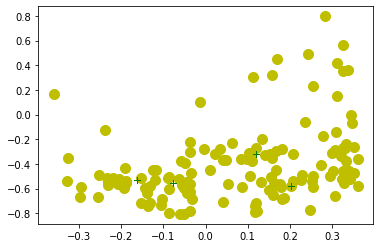

                0      1      2     3      4      5   7              8   9   \
0   1613728457.090 -0.189 -0.542 0.621 -0.162 -0.529   1 1613728457.730   1   
1   1613728521.030  0.284  0.798 0.620 -0.162 -0.529   1 1613728535.230   1   
2   1613728534.730 -0.206 -0.564 0.626 -0.162 -0.529   1 1613728535.230   1   
3   1613728541.980 -0.234 -0.517 0.625 -0.162 -0.529   1 1613728542.490   1   
4   1613728595.280 -0.360  0.166 0.624 -0.162 -0.529   0 1613728612.970   1   
5   1613728612.470 -0.220 -0.517 0.623 -0.162 -0.529   1 1613728612.970   1   
6   1613728620.270 -0.231 -0.558 0.623 -0.162 -0.529   1 1613728621.290   1   
7   1613728641.900 -0.254 -0.667 0.623 -0.162 -0.529   0 1613728683.010   1   
8   1613728644.040 -0.087 -0.798 0.621 -0.162 -0.529   0 1613728683.010   1   
9   1613728648.060  0.248 -0.771 0.621 -0.162 -0.529   0 1613728683.010   1   
10  1613728673.810 -0.106 -0.729 0.621 -0.162 -0.529   0 1613728683.010   1   
11  1613728682.510 -0.206 -0.522 0.628 -0.162 -0.529

Match found making rearing file


[]


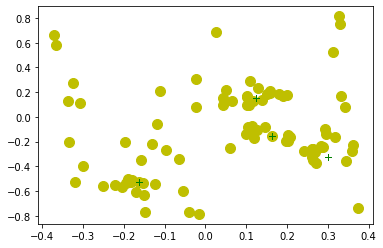

 found!
 found! 
Match found making rearing file


[]


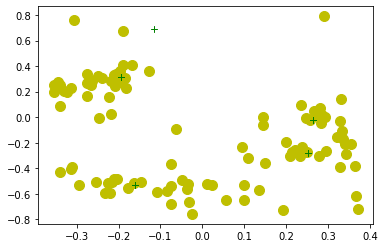

 found!
 found! 
Match found making rearing file

[]


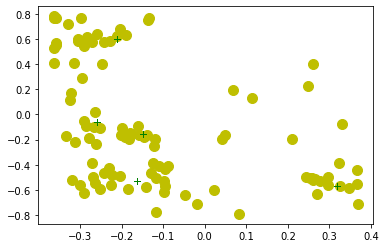

 found!
 found! 
Match found making rearing file




[]


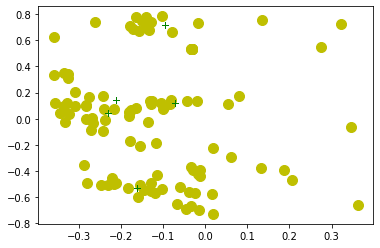

 found!
 found! 
Match found making rearing file


[]


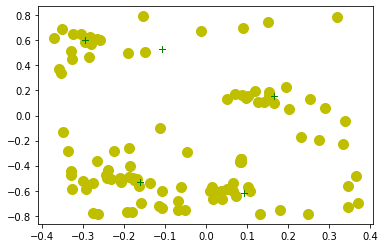

 found!
 found! 
Match found making rearing file





[]


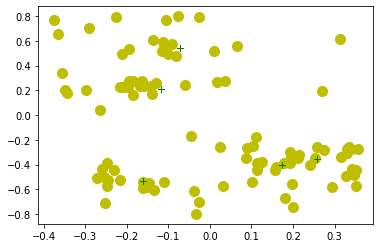

 found!
 found! 
Match found making rearing file

[]


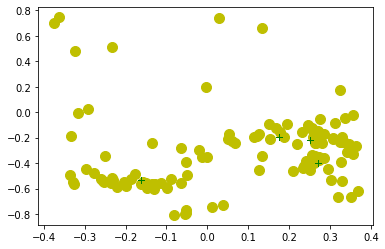

 found!
 found! 
Match found making rearing file


[]


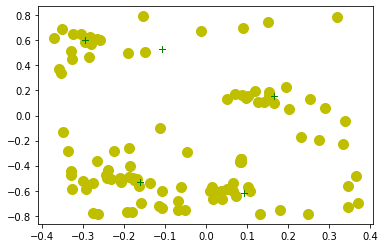

 found!
 found! 
Match found making rearing file

[]


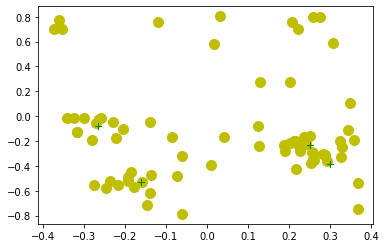

 found!
 found! 
Match found making rearing file

[]


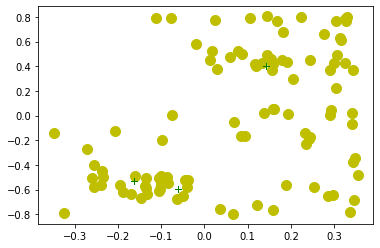

 found!
 found! 
Match found making rearing file
[]


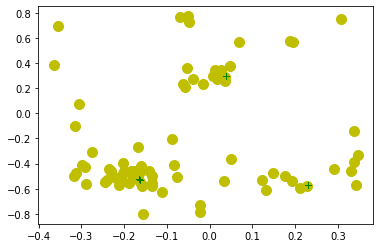

 found!
 found! 
Match found making rearing file



[]


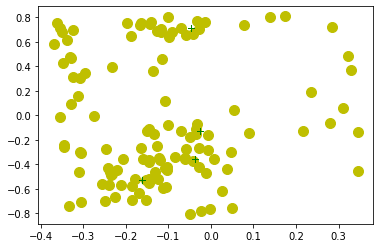

 found!
 found! 
Match found making rearing file


[]


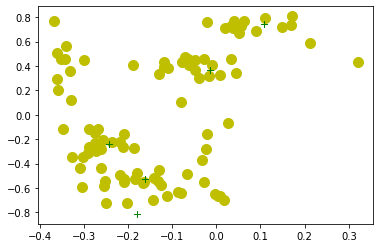

 found!
 found! 
Match found making rearing file



[]


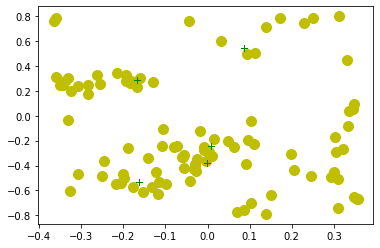

 found!
 found! 
Match found making rearing file

[]


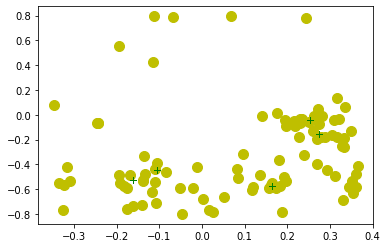

 found!
 found! 
Match found making rearing file



[]


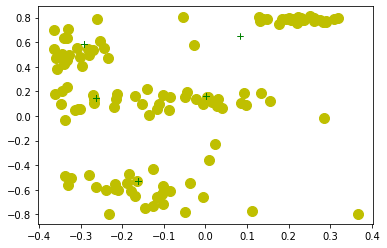

 found!
 found! 
Match found making rearing file

[]


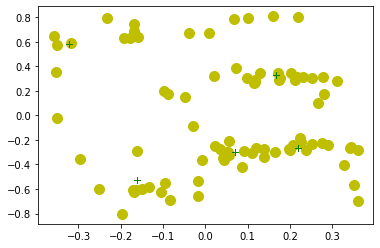

 found!
 found! 
Match found making rearing file


[]


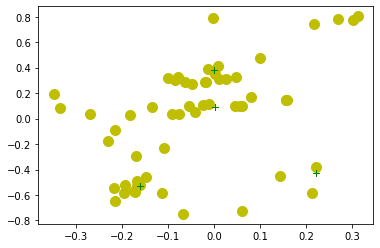

 found!
 found! 
Match found making rearing file

[]


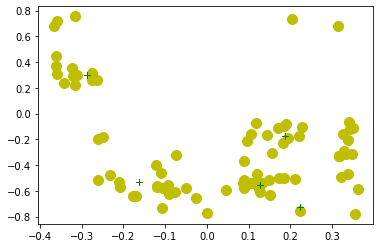

 found!
 found! 
Match found making rearing file



[]


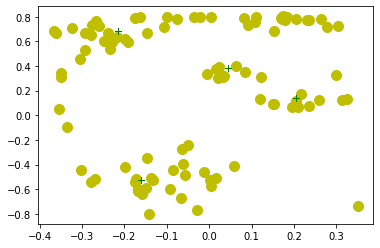

 found!
 found! 
Match found making rearing file



[]


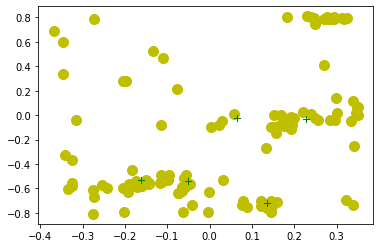

 found!
 found! 
Match found making rearing file



[]


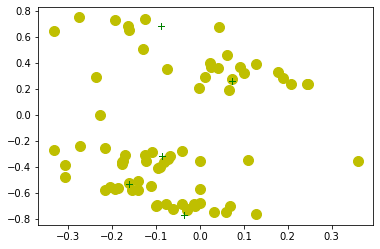

 found!
 found! 
Match found making rearing file

[]


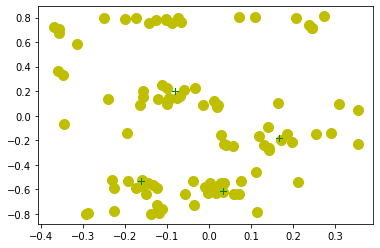

 found!
 found! 
Match found making rearing file

[]


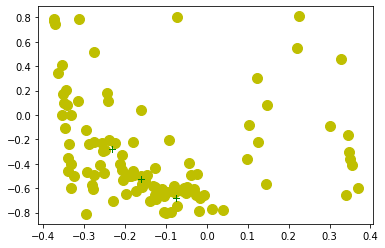

 found!
 found! 
Match found making rearing file

[]


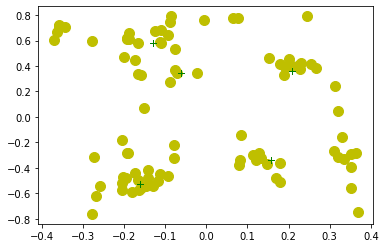

 found!
 found! 
Match found making rearing file


[]


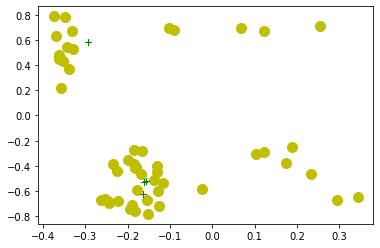

 found!
 found! 
Match found making rearing file

[]


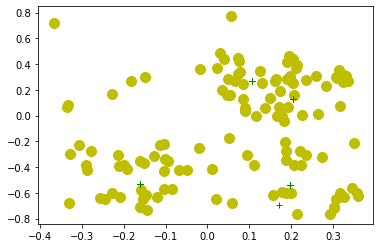

 found!
 found! 
Match found making rearing file



[]


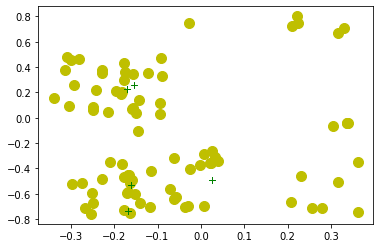

 found!
 found! 
Match found making rearing file





[]


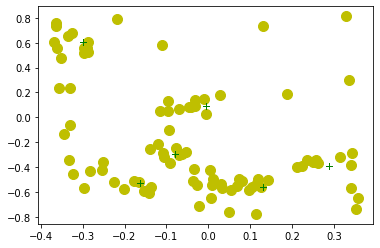

 found!
 found! 
Match found making rearing file






[]


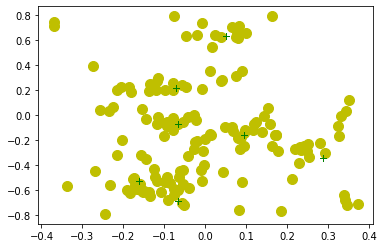

 found! 
bad match
 found!
 found! 
Match found making rearing file

[]


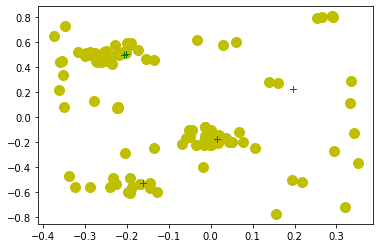

 found! 
bad match
 found!
 found! 
Match found making rearing file




[]


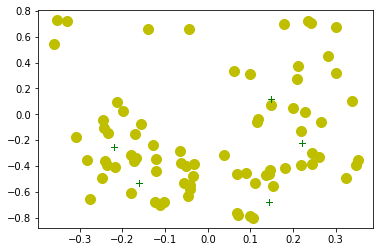

 found!
 found! 
Match found making rearing file



[]


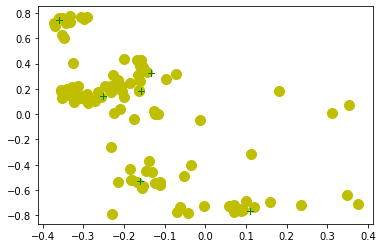

 found!
 found! 
Match found making rearing file





[]


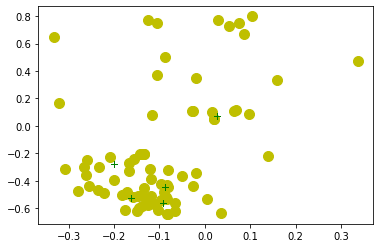

 found! 
bad match
 found!
 found! 
Match found making rearing file


[]


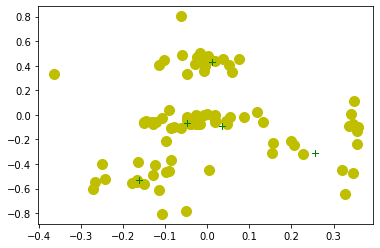

 found! 
bad match
 found!
 found! 
Match found making rearing file







[]


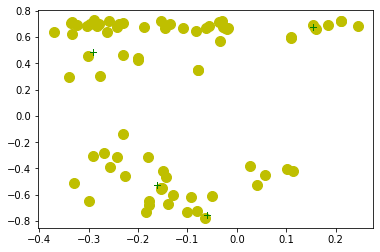

 found!
 found! 
Match found making rearing file





[]


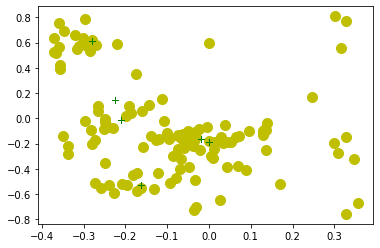

 found! 
bad match
 found! 
bad match
 found!
 found! 
Match found making rearing file






[]


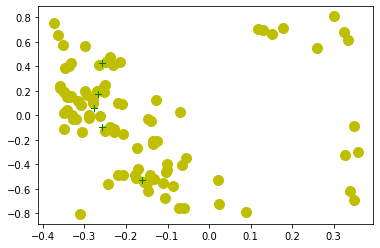

 found!
 found! 
Match found making rearing file



[]


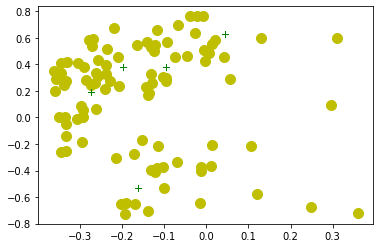

 found!
 found! 
Match found making rearing file







[]


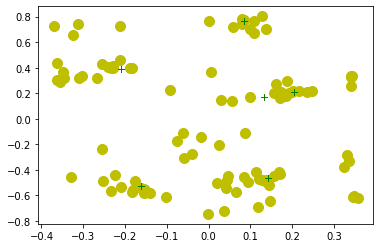

 found! 
bad match
 found!
 found! 
Match found making rearing file
[]


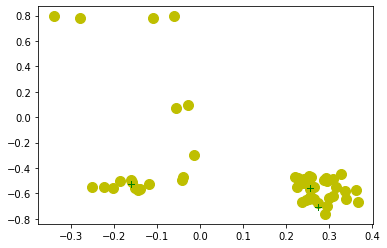

 found!
 found! 
Match found making rearing file






[]


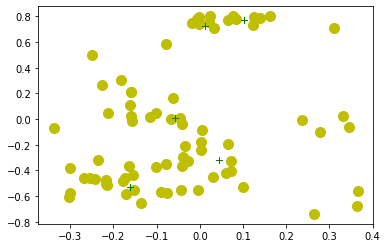

 found! 
bad match
 found!
 found! 
Match found making rearing file






[]


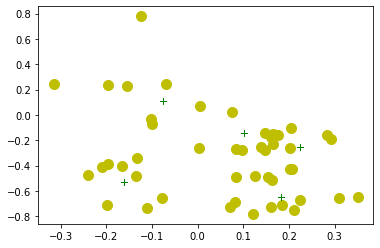

 found!
 found! 
Match found making rearing file


[]


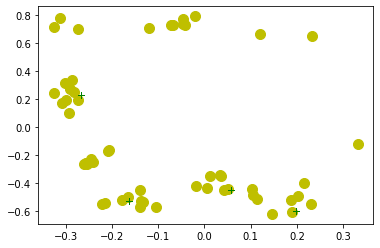

 found!
 found! 
Match found making rearing file








[]


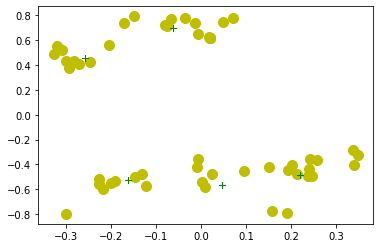

 found!
 found! 
Match found making rearing file










[]


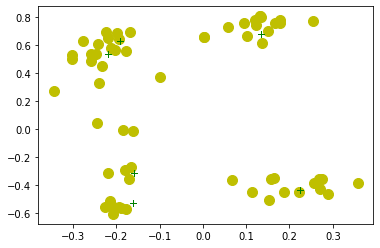

 found! 
bad match
 found!
 found! 
Match found making rearing file




[]


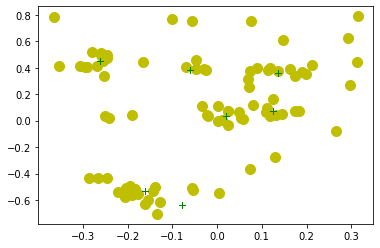

 found!
 found! 
Match found making rearing file






[]


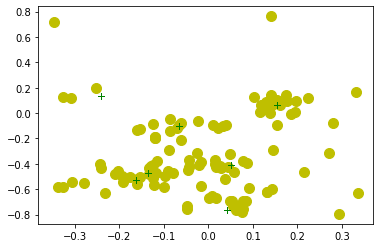

 found! 
bad match
 found!
 found! 
Match found making rearing file




[]


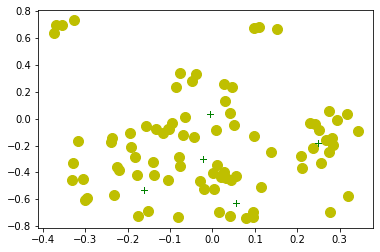

 found! 
bad match
 found! 
bad match
 found!
 found! 
Match found making rearing file


[]


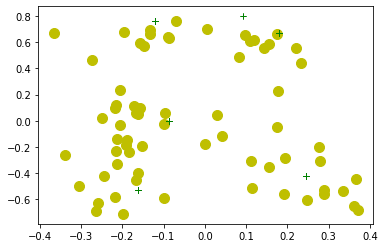

 found! 
bad match
 found! 
bad match
 found!
 found! 
Match found making rearing file

[]


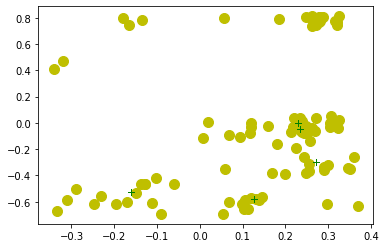

 found!
 found! 
Match found making rearing file


[]


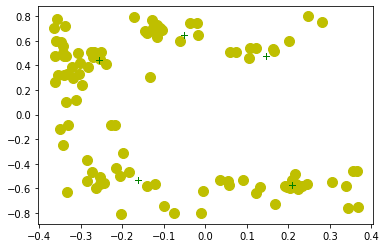

 found! 
bad match
 found! 
bad match
 found! 
bad match
 found! 
bad match
 found! 
bad match
 found! 
bad match
 found! 
bad match
 found! 
bad match
 found! 
bad match
 found! 
bad match
 found! 
bad match
 found!
 found! 
Match found making rearing file



[]


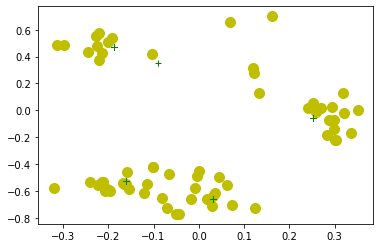

 found!
 found! 
Match found making rearing file
[]


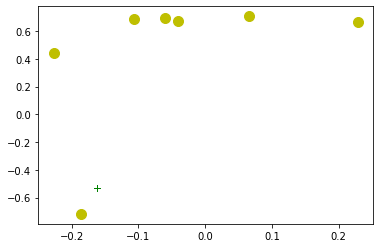

 found! 
bad match
 found! 
bad match
 found! 
bad match
 found! 
bad match
DataFrame made.
Matched 55 files


In [112]:
import os 

how_many= 0 

substring = "BPositions_"
position = "position_2"
beacon = 'beacons'
#animal = 'C:/Users/Fabian/Desktop/Analysis/Round3_FS03_FS06/Data/FS04/'
#animal = '//10.153.170.3/storage2/fabian/data/raw/FS03'
animal= '//10.153.170.3/storage2/fabian/Data/raw/FS04'    
average_rears=[]
rearing = pd.DataFrame()
for dirpath, dirnames, files in os.walk(animal, topdown=True):
    fullstring = dirpath
    for file_name in files:
        #print(f'Found directory: {dirpath}')
        #print(dirpath)
        #print('filename: HERE '+file_name)
        fullstring = dirpath
        #dirpath = dirpath.replace("\","/")
        #print(dirpath)
        if beacon in file_name:
            #print(file_name)
            print(" found!")
            beacons  = pd.read_csv(dirpath+'/'+file_name,sep=" ", header = None,engine='python')
            beacon_date = list(file_name)
        if position in file_name:
            #print(file_name)
            print(" found! ")
            positions = pd.read_csv(dirpath+'/'+file_name,sep=" ", header=None,engine='python')
            positions_date= list(file_name)
            if beacon_date[-9:]==positions_date[-9:]:
                print ("Match found making rearing file")
                how_many += 1
                rearing_df=make_rearing_df(positions,beacons)
                average_rears.append(len(rearing_df.index))
                plt.plot(rearing_df[1],rearing_df[2],'yo',ms=10)
                plt.plot(rearing_df[4],rearing_df[5],'g+')
                plt.show()
                
                if how_many<1.5:
                    rearing = rearing_df
                    print(rearing)
                else:
                    rearing = rearing.append(rearing_df,ignore_index=True)
                    
                #print(dirpath + '/'+ rename (file_name) +'.xlsx')
                #HSW_directory = dirpath.split(chr(92)+'B', 1)
                #print( HSW_directory[0])
            else: 
                print('bad match')

print('DataFrame made.')
            

print ('Matched %s files' %(how_many))

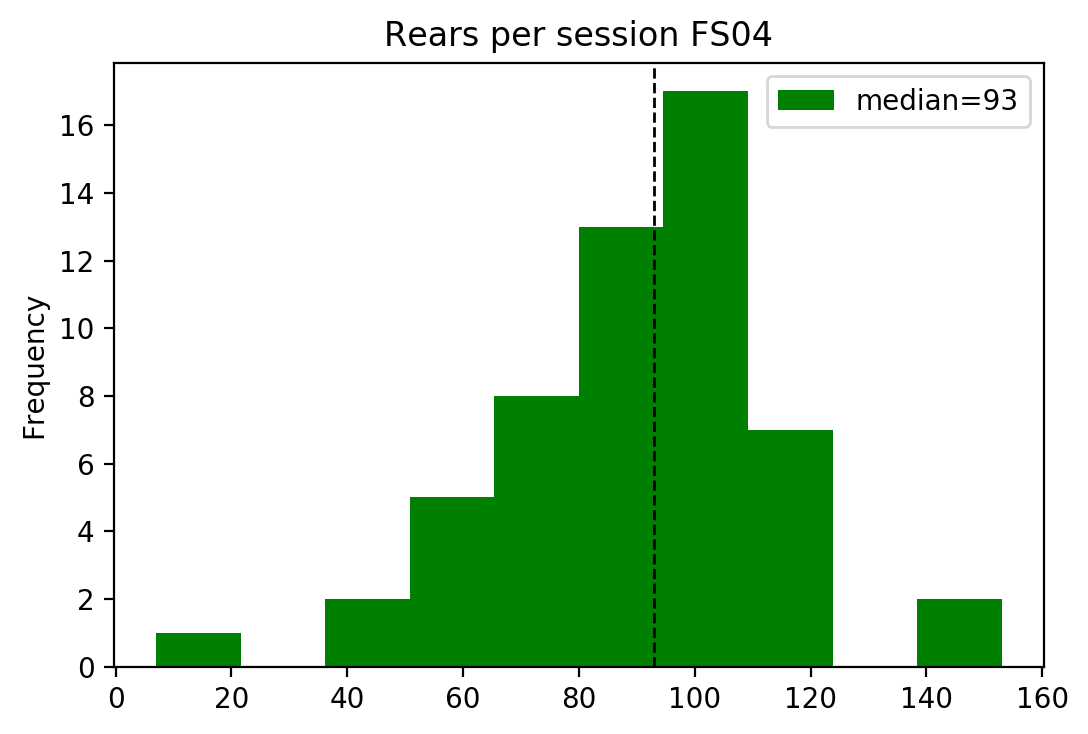

In [113]:
rat_ID= 'FS04'
import statistics
fig, ax = plt.subplots(1,1,dpi=200,sharex=False)
ax.hist(average_rears,color="green", label='median=%s' %(statistics.median(average_rears)))
ax.set_title('Rears per session '+rat_ID)
ax.axvline(statistics.median(average_rears), color='k', linestyle='dashed', linewidth=1)
ax.set_ylabel('Frequency')
ax.legend()
plt.savefig('%srears_per_session_%s.png'%(figures,rat_ID), dpi = 100)


In [114]:
rearing

,0,1,2,3,4,5,7,8,9,10,11
0,1613728457.090,-0.189,-0.542,0.621,-0.162,-0.529,1,1613728457.730,1,1,True
1,1613728521.030,0.284,0.798,0.620,-0.162,-0.529,1,1613728535.230,1,2,True
2,1613728534.730,-0.206,-0.564,0.626,-0.162,-0.529,1,1613728535.230,1,2,False
3,1613728541.980,-0.234,-0.517,0.625,-0.162,-0.529,1,1613728542.490,1,3,True
4,1613728595.280,-0.360,0.166,0.624,-0.162,-0.529,0,1613728612.970,1,4,True
5,1613728612.470,-0.220,-0.517,0.623,-0.162,-0.529,1,1613728612.970,1,4,False
6,1613728620.270,-0.231,-0.558,0.623,-0.162,-0.529,1,1613728621.290,1,5,True
7,1613728641.900,-0.254,-0.667,0.623,-0.162,-0.529,0,1613728683.010,1,6,True
8,1613728644.040,-0.087,-0.798,0.621,-0.162,-0.529,0,1613728683.010,1,6,False
9,1613728648.060,0.248,-0.771,0.621,-0.162,-0.529,0,1613728683.010,1,6,False


### E. Name all columns 

In [115]:
rearing.columns=["Time", "RatX","RatY", "RatZ","BeaconX", "BeaconY","Visibility","time_of_beacon_trigger","Beacon_group",'Beacon_subgroup','trial_in_next', ]
writer = pd.ExcelWriter(processed +'FS04_rears_new.xlsx')
rearing.to_excel(writer)
writer.save()

### Create histogram of how far away from beacon when reared for all first  need to subtract differetn beacon location each time 

### BEACON ANALYSIS 

#### First calculate distance

In [110]:
def calculate_Distance(x,y): 
        """Calculates distance given position"""
        travel=0
        for i in range(len(y)-1):
            dist = math.sqrt((x[0+i] - x[1+i])**2 + (y[0+i] - y[1+i])**2)
            travel+=dist

        return travel 

### Histogram of distance from beacon for all rears

(array([2865., 1055.,  467.,  423.,  284.,  240.,  163.,  220.,  264.,
          77.]),
 array([0.00173066, 0.16082232, 0.31991398, 0.47900564, 0.6380973 ,
        0.79718896, 0.95628062, 1.11537228, 1.27446394, 1.43355561,
        1.59264727]),
 <a list of 10 Patch objects>)

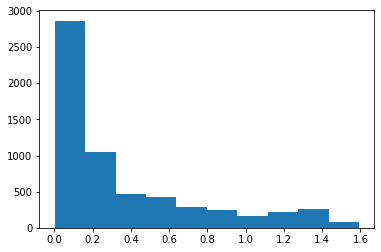

In [111]:
def get_rear_distance_from_beacon(df_rears_corrected):
    dist=[]
    for row in df_rears_corrected.iterrows():
        #print(row[1][1])
        #print(row[1][4])
        #print(row[1][2])
        #print(row[1][5])
        dist.append(math.sqrt((row[1][1] - row[1][4])**2 + (row[1][2] - row[1][5])**2))

    return dist 
plt.hist(get_rear_distance_from_beacon(rearing))

## Only for invisible succesfull

(array([594., 410., 192., 140.,  90.,  93.,  52.,  63.,  99.,  19.]),
 array([0.00388188, 0.16064944, 0.31741699, 0.47418454, 0.63095209,
        0.78771965, 0.9444872 , 1.10125475, 1.2580223 , 1.41478985,
        1.57155741]),
 <a list of 10 Patch objects>)

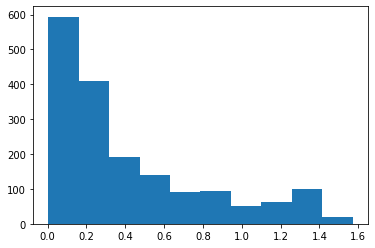

In [138]:
plt.hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==3]))

## For visible succesful

(array([1329.,  510.,  250.,  265.,  170.,  131.,  112.,  148.,  147.,
          51.]),
 array([0.00319437, 0.16213966, 0.32108495, 0.48003024, 0.63897553,
        0.79792082, 0.95686611, 1.1158114 , 1.27475669, 1.43370198,
        1.59264727]),
 <a list of 10 Patch objects>)

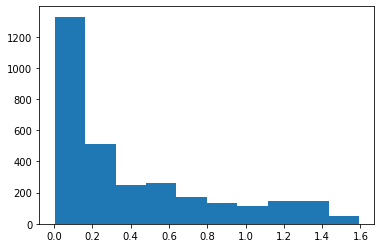

In [139]:
plt.hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==1]))

### For visible only 

(array([815.,  99.,  16.,  11.,  11.,   4.,   6.,   2.,  10.,   2.]),
 array([0.00173066, 0.1520149 , 0.30229915, 0.45258339, 0.60286763,
        0.75315188, 0.90343612, 1.05372036, 1.20400461, 1.35428885,
        1.50457309]),
 <a list of 10 Patch objects>)

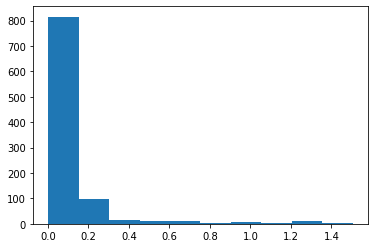

In [142]:
plt.hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==0]))

### Invisible but succesfull

(array([120.,  54.,  13.,  10.,   2.,   6.,   3.,   2.,   4.,   3.]),
 array([0.00839527, 0.15135158, 0.2943079 , 0.43726422, 0.58022053,
        0.72317685, 0.86613317, 1.00908948, 1.1520458 , 1.29500212,
        1.43795843]),
 <a list of 10 Patch objects>)

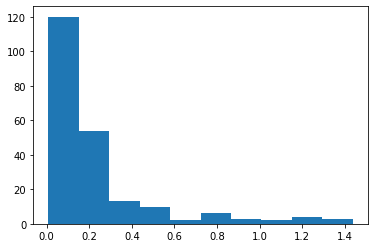

In [146]:
plt.hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==2]))

In [116]:
processed= 'C:/Users/Fabian/Desktop/Analysis/Round3_FS03_FS06/processed/'
rearing_FS04 = pd.read_excel(processed + 'FS04_rears_new.xlsx',index_col=0)
rearing_FS03 = pd.read_excel(processed + 'FS03_rears_new.xlsx',index_col=0)
rearing_FS03.head()


,Time,RatX,RatY,RatZ,BeaconX,BeaconY,Visibility,time_of_beacon_trigger,Beacon_group,Beacon_subgroup,trial_in_next
0,1608550224.000,0.101,-0.118,0.624,-0.162,-0.529,1,1608550320.980,1,1,True
1,1608550231.550,-0.344,0.785,0.621,-0.162,-0.529,1,1608550320.980,1,1,False
2,1608550239.480,-0.087,-0.517,0.622,-0.162,-0.529,1,1608550320.980,1,1,False
3,1608550253.090,-0.027,-0.707,0.622,-0.162,-0.529,1,1608550320.980,1,1,False
4,1608550266.690,-0.235,-0.457,0.627,-0.162,-0.529,1,1608550320.980,1,1,False


In [173]:
binwidth=.075
bins=np.arange(0, 1.5 + binwidth, binwidth)
bins[1]= 0.085
bins

array([0.   , 0.085, 0.15 , 0.225, 0.3  , 0.375, 0.45 , 0.525, 0.6  ,
       0.675, 0.75 , 0.825, 0.9  , 0.975, 1.05 , 1.125, 1.2  , 1.275,
       1.35 , 1.425, 1.5  ])

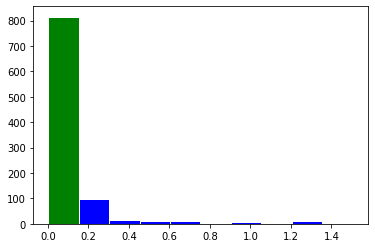

In [174]:
fig, ax = plt.subplots()
data = (get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==0]))

N, bins, patches = ax.hist(data, edgecolor='white', linewidth=1)

for i in range(0,1):
    patches[i].set_facecolor('g')
for i in range(1, len(patches)):
    patches[i].set_facecolor('blue')

plt.show()

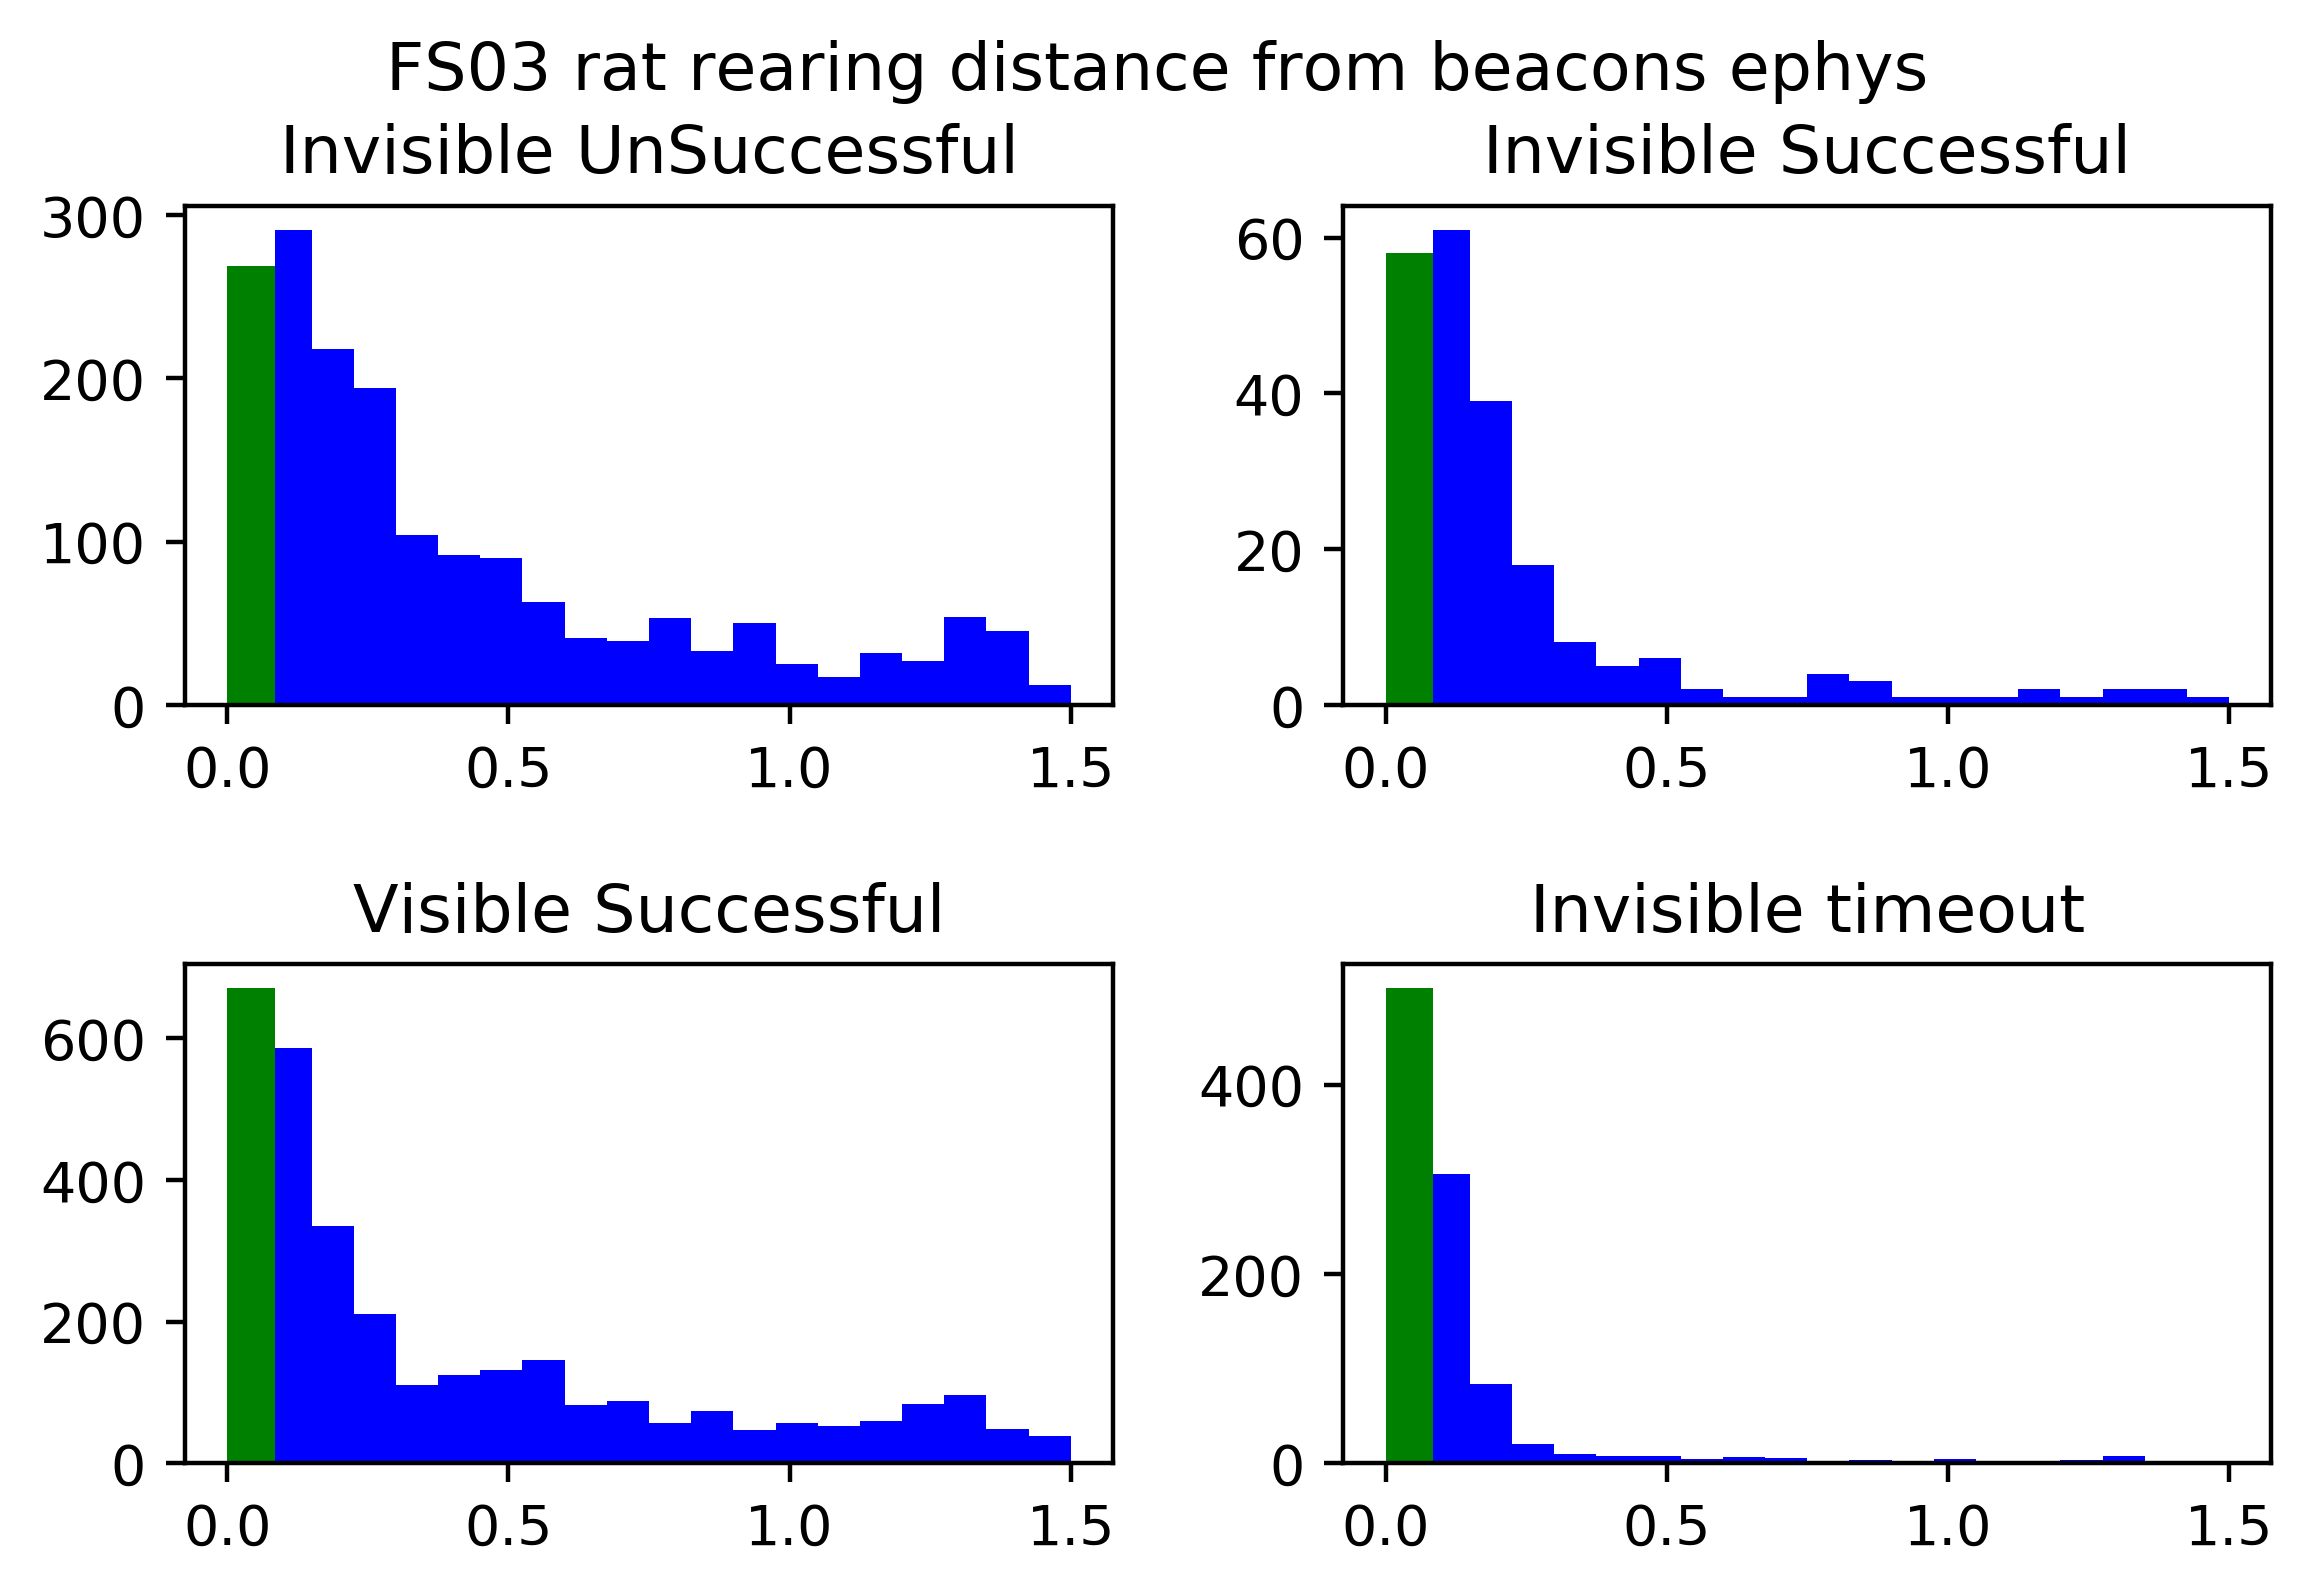

In [175]:
#rearing = 
def make_graphs (animal_ID,rearing):
    
    plt.tight_layout
    bins = np.arange(0, 1.5 + binwidth, binwidth)
    bins[1]= 0.085
    fig, ax = plt.subplots(2,2,dpi=400,sharex=False)
    fig.suptitle(animal_ID +' rat rearing distance from beacons ephys',y=1)
    #ax[0][0].bar(day_list_short,sorted_data['Pellets'],label='pellets',color ='g')
    #ax[0][0].bar(day_list_short,sorted_data['high pellets'],label='high pellets',color ='y')
#     ax[0][0].set_title('1 session')
#     ax[0][0].legend(loc='upper left',prop={'size': 5})
#     ax[0][0].plot(rr[1],rr[2],'bo',ms=2)
#     ax[0][0].plot([(X_cut_min+cut)-x_offset,(X_cut_max-cut)-x_offset],[(Y_cut_max-cut)+y_offset,(Y_cut_max-cut)+y_offset] ,'r-')
#     ax[0][0].plot([(X_cut_min+cut)-x_offset,(X_cut_min+cut)-x_offset],[(Y_cut_min+cut)+y_offset,(Y_cut_max-cut)+y_offset] ,'r-')
#     ax[0][0].plot([(X_cut_max-cut)-x_offset,(X_cut_max-cut)-x_offset],[(Y_cut_min+cut)+y_offset,(Y_cut_max-cut)+y_offset] ,'r-')
#     ax[0][0].plot([(X_cut_max-cut)-x_offset,(X_cut_min+cut)-x_offset],[(Y_cut_min+cut)+y_offset,(Y_cut_min+cut)+y_offset] ,'r-')
#     ax[0][0].scatter(rr[4],rr[5],s=220,marker='o', facecolors='none', edgecolors='green')
    #ax[1][1].set_xlabel('day')
    #ax[1][0].set_xlabel('day')
    #ax[0][0].set_ylabel('pellets')
    
    N, bins, patches=ax[0][0].hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==3]),bins=bins)
#     ax[0][1].plot(day_list_short,sorted_data['Sham'],label = 'sham')
#     ax[0][1].legend(loc='upper left',prop={'size': 5})
    ax[0][0].set_title('Invisible UnSuccessful')
#     #ax[0][1].set_ylabel('time in beacon')
    for i in range(0,1):
        patches[i].set_facecolor('g')
    for i in range(1, len(patches)):
        patches[i].set_facecolor('blue')
        fig.tight_layout(pad=1.5)


    N, bins, patches=ax[0][1].hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==2]),bins=bins)
#     ax[0][1].plot(day_list_short,sorted_data['Sham'],label = 'sham')
#     ax[0][1].legend(loc='upper left',prop={'size': 5})
    ax[0][1].set_title('Invisible Successful')
#     #ax[0][1].set_ylabel('time in beacon')
    for i in range(0,1):
        patches[i].set_facecolor('g')
    for i in range(1, len(patches)):
        patches[i].set_facecolor('blue')
        fig.tight_layout(pad=1.5)
    N, bins, patches=ax[1][0].hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==1]),bins=bins)
#     ax[1][0].plot(day_list_short,sorted_data['Distance'], label = 'distance')
#     ax[1][0].legend(loc='upper left',prop={'size': 5})
    ax[1][0].set_title('Visible Successful')
#     ax[1][0].set_ylabel('meters')
#     ax[1][0].tick_params(axis="x", labelsize=6, labelrotation=-60, labelcolor="turquoise")

    for i in range(0,1):
        patches[i].set_facecolor('g')
    for i in range(1, len(patches)):
        patches[i].set_facecolor('blue')
        fig.tight_layout(pad=1.5)
    

    N, bins, patches = ax[1][1].hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==0]),bins=bins)
#     ax[1][1].plot(day_list_short,sorted_data['Speed'],label= 'speed',color = 'cyan')
#     ax[1][1].legend(loc='upper left',prop={'size': 5})
    ax[1][1].set_title('Invisible timeout')
#     ax[1][1].tick_params(axis="x", labelsize=6, labelrotation=-60, labelcolor="turquoise")
    
    for i in range(0,1):
        patches[i].set_facecolor('g')
    for i in range(1, len(patches)):
        patches[i].set_facecolor("blue")
        fig.tight_layout(pad=1.5)
    
    #plt.show()
    plt.savefig('%sPOST_Calib_rat_rearing_distance_from_beacons_hist_only%s.png'%(figures,animal_ID), dpi = 100)

    
make_graphs('FS03' ,rearing_FS03)    

### To simplify show attempts when beacon visible and rears when beacon invisible. This of course includes the time when the animla goes out to search for a pellet even if beacon visible.  

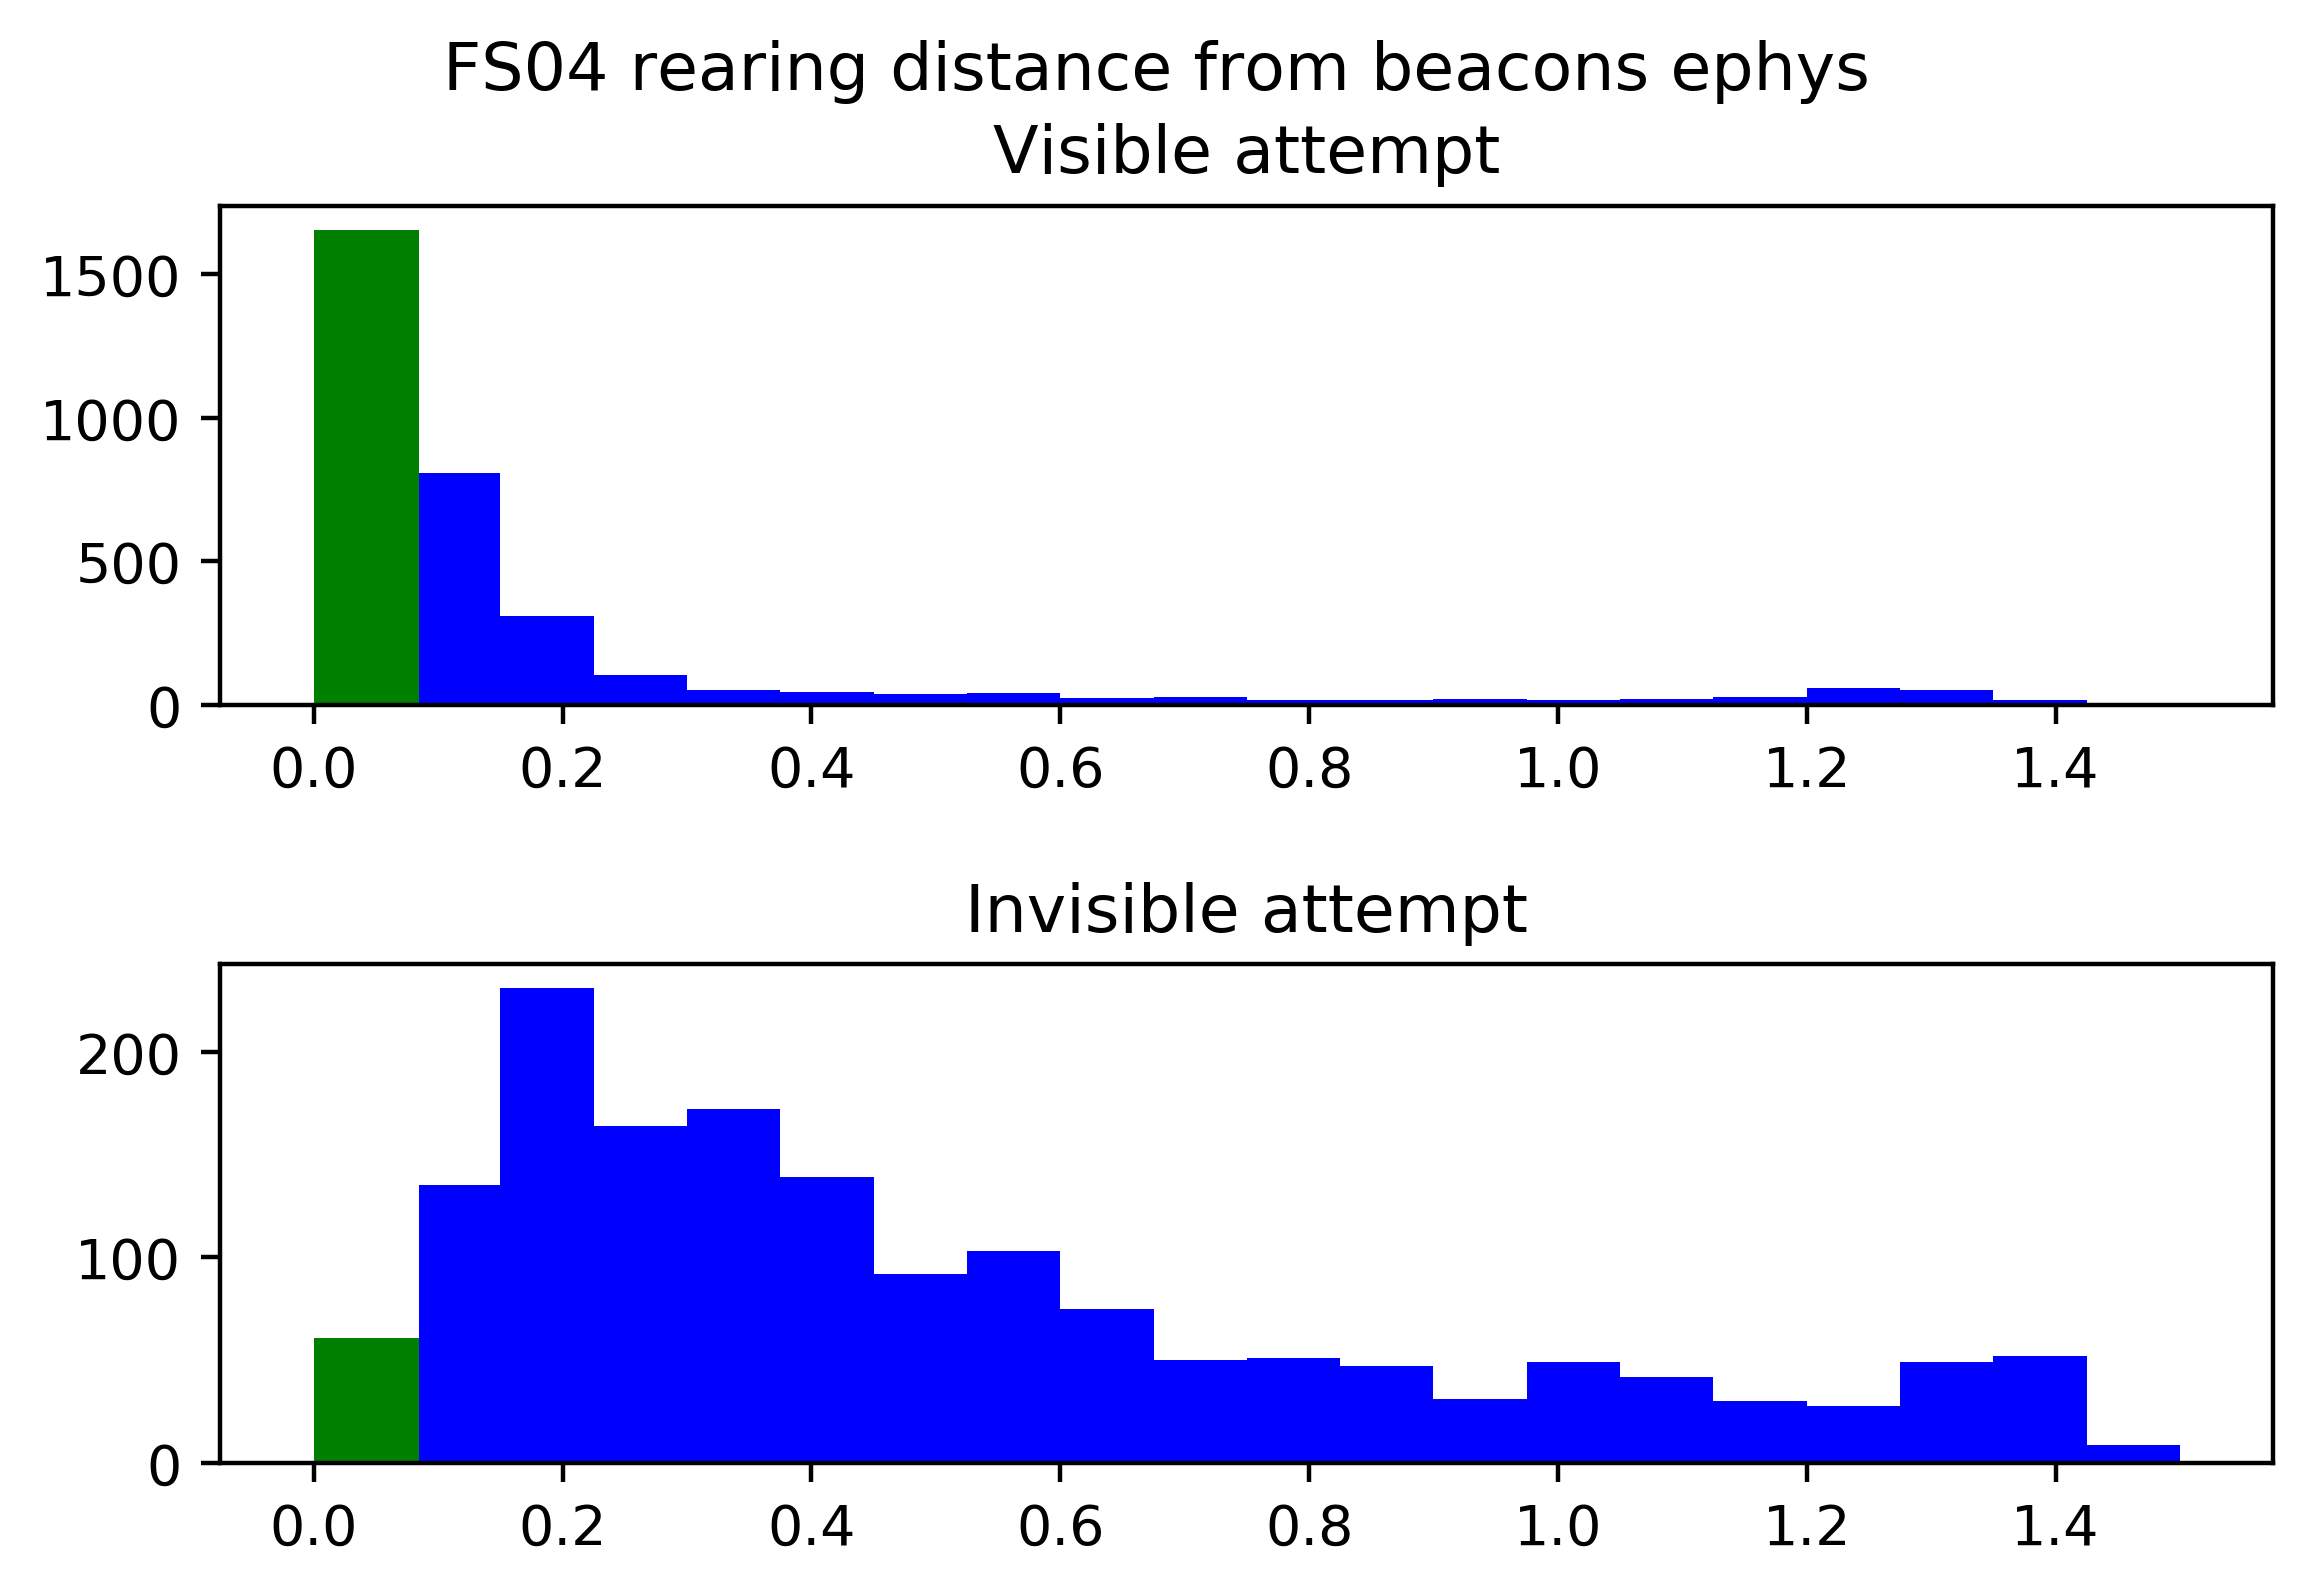

In [119]:
def make_simple_graphs (animal_ID,rearing):
    binwidth=.075
    plt.tight_layout
    bins = np.arange(0, 1.5 + binwidth, binwidth)
    bins[1]= 0.085
    fig, ax = plt.subplots(2,dpi=400,sharex=False)
    fig.suptitle(animal_ID +' rearing distance from beacons ephys',y=1)

    N, bins, patches=ax[0].hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==1]),bins=bins)
    ax[0].set_title('Visible attempt')
    for i in range(0,1):
        patches[i].set_facecolor('g')
    for i in range(1, len(patches)):
        patches[i].set_facecolor('blue')
        fig.tight_layout(pad=1.5)
        
    N, bins, patches=ax[1].hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==0]),bins=bins)
    ax[1].set_title('Invisible attempt')
    for i in range(0,1):
        patches[i].set_facecolor('g')
    for i in range(1, len(patches)):
        patches[i].set_facecolor('blue')
        fig.tight_layout(pad=1.5)
    plt.savefig('%srat_rearing_distance_from_beacons_simple%s.png'%(figures,animal_ID), dpi = 100)

    
make_simple_graphs('FS04' ,rearing_FS04) 

# GRAVEYARD`

## Try to catch so that it is the smallest value int the beacon 

In [17]:
df_rears = Z_points
Xs=[]
Ys=[]
for row in Z_points.iterrows():
    #print(row[1][0])

    k = FS03_beacon.iloc[(FS03_beacon[0] - row[1][0]).abs().argsort()[:1]]
    #print(k.values[0][4])
    

    timept = k.values[0][0]
    while timept > row[1][0] and k.index>0:
        
        timept = k.values[0][0]
        k_idx = k.index
        k = FS03_beacon.iloc[k_idx-1] 
        
    Xs.append(k.values[0][4])
    Ys.append(k.values[0][5])


    #print(FS03_position[0][list(k.index)])
    #pos_index.append(int(''.join(map(str,list(k.index)))))
df_rears[4]=Xs
df_rears[5]=Ys
#df_rears

In [18]:
pos_index=[]
invis=[]
#for ind in FS03_beacon.index:
df = FS03_beacon[0].diff().to_frame()
for ind in df.index:
    if df[0][ind]<60 and not (ind % 2 == 0):
        invis.append(ind)
        #print(FS03_beacon[0][ind])
        k = FS03_position.iloc[(FS03_position[0] - FS03_beacon[0][ind]).abs().argsort()[:1]]
        #print(list(k.index))
        #print(FS03_position[0][list(k.index)])
        pos_index.append(int(''.join(map(str,list(k.index)))))
invis
pos_index

[11402, 23433, 56610, 70657, 105457]

In [19]:
pos_index=[]
invis=[]
#for ind in FS03_beacon.index:
df = FS03_beacon[0].diff().to_frame()
for ind in df.index:
    if df[0][ind]<60 and not (ind % 2 == 0):
        invis.append(ind)
        #print(FS03_beacon[0][ind])
        k = Z_points.iloc[(Z_points[0] - FS03_beacon[0][ind]).abs().argsort()[:1]]
        #print(list(k.index))
        #print(FS03_position[0][list(k.index)])
        pos_index.append(int(''.join(map(str,list(k.index)))))
invis
pos_index

[11, 23, 59, 77, 100]

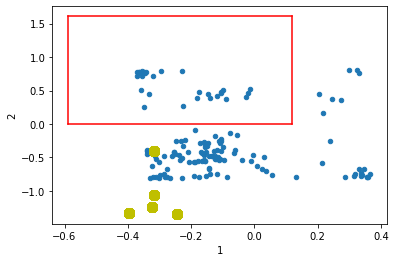

areas: -1.1431


In [71]:
cut=0
Z_points.plot.scatter(x=1, y=2)
plt.plot([(X_cut_min+cut),(X_cut_max-cut)],[(Y_cut_max-cut),(Y_cut_max-cut)] ,'r-')
plt.plot([(X_cut_min+cut),(X_cut_min+cut)],[(Y_cut_min+cut),(Y_cut_max-cut)] ,'r-')
plt.plot([(X_cut_max-cut),(X_cut_max-cut)],[(Y_cut_min+cut),(Y_cut_max-cut)] ,'r-')
plt.plot([(X_cut_max-cut),(X_cut_min+cut)],[(Y_cut_min+cut),(Y_cut_min+cut)] ,'r-')
plt.plot(rr[4]+x_offset,rr[5]-y_offset,'yo',ms=10)

plt.savefig('%srears_all.png' %(figures), dpi = 200) 

plt.show()
print ('areas: %s' %((X_cut_min-X_cut_max)*(Y_cut_max-Y_cut_min))) 

In [38]:
rearing = beacon_group(rearing)
change = rearing[7]
rearing.drop(labels=['Mid'], axis=1,inplace = True)
rearing.insert(7, 'Change', change)
rearing.head()

KeyError: "['Mid'] not found in axis"